## 테스트용 파일이름 추출 및 정리
### 캡션 예측용 사진 다운로드
### 모델훈련시 저장한 테스트용 데이터 파일 로드 후 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [3]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)


else:
  PATH = os.path.abspath('.') + image_folder

image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 118s 0us/step


In [4]:
# 드라이브에 폴더생성
os.mkdir("/content/Multi")

In [5]:
!unzip -uq "/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MultiModule.zip" -d "/content/Multi/"

In [6]:
len(os.listdir("/content/Multi"))

24010

In [7]:
PATH = '/content/'

In [8]:
# import pandas as pd
df_MS = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/MS_COCO_데이터정리(완료).csv')
df_MS['사진경로'] = PATH + df_MS['사진경로']
print(len(df_MS))
df_MS.head()

616767


,사진경로,캡셔닝_데이터
0,/content/val2014/COCO_val2014_000000391895.jpg,빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장도로를 달려 있다
1,/content/val2014/COCO_val2014_000000391895.jpg,시골의 비포장도로에서 오토바이를 타는 남자
2,/content/val2014/COCO_val2014_000000391895.jpg,오토바이 뒤에 탄 남자
3,/content/val2014/COCO_val2014_000000391895.jpg,오토바이 위에 젊은이가 탄 비포장도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 ...
4,/content/val2014/COCO_val2014_000000391895.jpg,빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다


In [10]:
# import pandas as pd
df_Multi = pd.read_csv('/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/02. 데이터/caption/멀티모달_데이터정리(완료).csv')
df_Multi['사진경로'] = '/content/' + df_Multi['사진이름']
print(len(df_Multi))
df_Multi.head()

119825


,사진경로,사진이름,캡셔닝_데이터(종합),캡셔닝_데이터,캡셔닝_데이터(수정)
0,/content/KETI_SHOT_0000145756_KM_0000000448.jpg,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들이 있다,start 남자들이 있다 end
1,/content/KETI_SHOT_0000145756_KM_0000000448.jpg,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들은 서로 쳐다보고 있다,start 남자들은 서로 쳐다보고 있다 end
2,/content/KETI_SHOT_0000145756_KM_0000000448.jpg,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 검정 머리이다,start 남자는 검정 머리이다 end
3,/content/KETI_SHOT_0000145756_KM_0000000448.jpg,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 흰 셔츠를 입고 있다,start 남자는 흰 셔츠를 입고 있다 end
4,/content/KETI_SHOT_0000145756_KM_0000000448.jpg,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 옆을 보고 있다,start 남자는 옆을 보고 있다 end


In [35]:
# 테스트용 파일 이름 csv 호출
# import pandas as pd
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoints(Ko)/testImage_Name.csv')
print(len(df_test))
df_test.head()

14727


,testImage_Name
0,/content/train2014/COCO_train2014_000000457734...
1,/content/train2014/COCO_train2014_000000306060...
2,/content/train2014/COCO_train2014_000000283666...
3,/content/train2014/COCO_train2014_000000452985...
4,/content/train2014/COCO_train2014_000000318924...


In [40]:
# BLEU 레퍼렌스 데이터 추출
df_test_bleu = pd.merge(df_test, df_MS, left_on='testImage_Name', right_on='사진경로', how='left')[['사진경로', '캡셔닝_데이터']]
df_test_bleu.head(10)

,사진경로,캡셔닝_데이터
0,/content/train2014/COCO_train2014_000000457734...,한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다
1,/content/train2014/COCO_train2014_000000457734...,어른 얼룩말이 차의 조수석 창문 근처에 서 있다
2,/content/train2014/COCO_train2014_000000457734...,밝은 날에 차 옆에 서 있는 얼룩말
3,/content/train2014/COCO_train2014_000000457734...,차량 근처에 서 있는 얼룩말의 근접 촬영지입니다
4,/content/train2014/COCO_train2014_000000457734...,얼룩말과 측면 거울에 비친 암컷
5,/content/train2014/COCO_train2014_000000306060...,두 사람이 해변에서 말을 타고 있다
6,/content/train2014/COCO_train2014_000000306060...,남자와 여자가 해변에서 말을 타고 있다
7,/content/train2014/COCO_train2014_000000306060...,해변에 두 마리의 갈색 말을 탄 남자와 여자가 있다
8,/content/train2014/COCO_train2014_000000306060...,해변에서 말을 타는 소녀와 남자
9,/content/train2014/COCO_train2014_000000306060...,두 사람이 해변에서 말을 타고 있다


## 체크포인트 불러와서 테스트할 모델 로드하기


In [41]:
# 사진 리사이징시 오류가 생기는 사진 파일 제외
df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000142253_KM_0000014468.jpg']
df_Multi = df_Multi[df_Multi['사진이름'] != 'KETI_SHOT_0000123067_KM_0000000834.jpg']
df_Multi.reset_index(drop = True, inplace = True)

In [42]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) 
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [43]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [44]:
# Feel free to change these parameters according to your system's configuration
# 해당 모델에 들어가야하는 필수 변수들이며, 학습시킬때의 수치와 일치화 시켜주었습니다.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 76344
max_length = 41
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [45]:
import pandas as pd
df_Tk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoints(Ko)/tokenizer(index_word).csv')
df_Tk.head()

,key,value
0,1,<unk>
1,2,<start>
2,3,<end>
3,4,있다
4,5,있는


In [47]:
top_k = 76344
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.word_index = dict(zip(df_Tk['value'], df_Tk['key']))
tokenizer.index_word = dict(zip(df_Tk['key'], df_Tk['value']))
len(tokenizer.index_word ) ,len(tokenizer.word_index)

(76343, 76343)

## 모델 로드

In [48]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [70]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [71]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/팀프로젝트/빅데이터 지능형 서비스과정(최종프로젝트)/Image_Captioning(MS COCO, Tensorflow)/checkpoints(Ko)/train(val_image)/'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50) 
ckpt.restore(ckpt_manager.latest_checkpoint)
# encoder.summary()
# decoder.summary()

In [72]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
# !pip install git+https://github.com/ssut/py-hanspell.git

In [73]:
import os
path_dir = '/content/val2014/'
file_dir = os.listdir(path_dir)
path_dir + file_dir[0]

'/content/val2014/COCO_val2014_000000512467.jpg'

/content/train2014/COCO_train2014_000000306060.jpg
예측문장1: 서핑 보드를 타고 해변으로 말을 타고 있는 여인 <end>
예측문장2: 비키니를 입은 수영복을 입은 여자가 서프보드를 잡고 있는 사람 <end>
예측문장3: 침대의 입힙니다 <end>
예측문장4: 말을 탄 부부가 편안한 바다에서 일어서 있었다 <end>
예측문장5: 두 명의 여자가 해마상에 다리를 걷고 있다 <end>


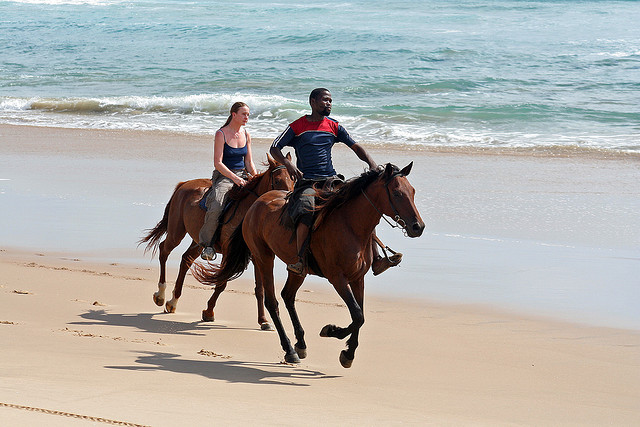

In [77]:
# from hanspell import spell_checker
import random 
i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# image_path = '/content/1.jpg'
# image_path = path_dir + file_dir[i]
image_path = df_test_bleu['사진경로'][6]
print(image_path)

prediction_list = []
for i in range(5):
  result, attention_plot = evaluate(image_path)
  caption = ' '.join(result)
  print(f'예측문장{i+1}:', caption)
  # print(f'예측문장{i+1}(원래문장):', ' '.join(result))
  prediction_list.append(caption)
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## 모델 로드후 Bleu score 계산

In [56]:
df_test_bleu.head()

,사진경로,캡셔닝_데이터
0,/content/train2014/COCO_train2014_000000457734...,한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다
1,/content/train2014/COCO_train2014_000000457734...,어른 얼룩말이 차의 조수석 창문 근처에 서 있다
2,/content/train2014/COCO_train2014_000000457734...,밝은 날에 차 옆에 서 있는 얼룩말
3,/content/train2014/COCO_train2014_000000457734...,차량 근처에 서 있는 얼룩말의 근접 촬영지입니다
4,/content/train2014/COCO_train2014_000000457734...,얼룩말과 측면 거울에 비친 암컷


In [60]:
list(df_test_bleu[df_test_bleu['사진경로'] == df_test_bleu['사진경로'][0]]['캡셔닝_데이터'])

['한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다 ',
 '어른 얼룩말이 차의 조수석 창문 근처에 서 있다 ',
 '밝은 날에 차 옆에 서 있는 얼룩말',
 '차량 근처에 서 있는 얼룩말의 근접 촬영지입니다 ',
 '얼룩말과 측면 거울에 비친 암컷']

In [62]:
# df_test_bleu 딕셔너리 변환
from tqdm.notebook import tqdm
bleu_dict = dict()
for name in tqdm(df_test_bleu['사진경로']):
  bleu_dict[name] = list(df_test_bleu[df_test_bleu['사진경로'] == name]['캡셔닝_데이터'])

  0%|          | 0/73675 [00:00<?, ?it/s]

In [81]:
df_test.head()

,testImage_Name
0,/content/train2014/COCO_train2014_000000457734...
1,/content/train2014/COCO_train2014_000000306060...
2,/content/train2014/COCO_train2014_000000283666...
3,/content/train2014/COCO_train2014_000000452985...
4,/content/train2014/COCO_train2014_000000318924...


In [83]:
df_test['testImage_Name'][0]

'/content/train2014/COCO_train2014_000000457734.jpg'

In [84]:
len(bleu_dict), bleu_dict[df_test['testImage_Name'][0]]

(14727,
 ['한 여성이 자신의 자동차에서 얼룩말의 사진을 찍는다 ',
  '어른 얼룩말이 차의 조수석 창문 근처에 서 있다 ',
  '밝은 날에 차 옆에 서 있는 얼룩말',
  '차량 근처에 서 있는 얼룩말의 근접 촬영지입니다 ',
  '얼룩말과 측면 거울에 비친 암컷'])

In [79]:
# 참고사이트 : https://jrc-park.tistory.com/273
from nltk.translate.bleu_score import corpus_bleu # 레퍼렌스가 여러개일떄 sentence_bleu는 점수가 상승할 수 밖에 없음. / 여러문장을 비교할때는 corpus_bleu를 사용
from nltk.translate.bleu_score import sentence_bleu

def print_bleu(reference, candidate):
  # bleu_sentence = sentence_bleu(reference, candidate)
  bleu_1gram = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)) # weights를 0.25로 동일하게 주면 1gram부터 4gram까지 같은 수치로 계산(gram이 높아질 수록 연계된 순서를 2~4개까지 고려)

In [143]:
reference = [["this", "is", "the", "sample"]] 
	    #  ["this", "the", "good","sample"]]
candidate = ['this', "is", "a", "good", "sample"]
sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6

In [148]:
# 각 단어의 일치여부만 확인하는 유니그램형태로 분석.
references = bleu_dict[df_test['testImage_Name'][0]]
references = list(map(lambda ref: ref.split(), references))
references

[['한', '여성이', '자신의', '자동차에서', '얼룩말의', '사진을', '찍는다'],
 ['어른', '얼룩말이', '차의', '조수석', '창문', '근처에', '서', '있다'],
 ['밝은', '날에', '차', '옆에', '서', '있는', '얼룩말'],
 ['차량', '근처에', '서', '있는', '얼룩말의', '근접', '촬영지입니다'],
 ['얼룩말과', '측면', '거울에', '비친', '암컷']]

In [149]:
result, attention_plot = evaluate(df_test['testImage_Name'][0])
# result.remove('<end>')
candidate = result[:-1]
candidate

['한', '무리의', '얼룩말이', '떨어진', '나무', '옆에', '서', '있다']

In [150]:
sentence_bleu(references, candidate, weights=(1, 0, 0, 0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.625

In [151]:
references = bleu_dict[df_test['testImage_Name'][0]]
references = list(map(lambda ref: ref.split(), references))
references

[['한', '여성이', '자신의', '자동차에서', '얼룩말의', '사진을', '찍는다'],
 ['어른', '얼룩말이', '차의', '조수석', '창문', '근처에', '서', '있다'],
 ['밝은', '날에', '차', '옆에', '서', '있는', '얼룩말'],
 ['차량', '근처에', '서', '있는', '얼룩말의', '근접', '촬영지입니다'],
 ['얼룩말과', '측면', '거울에', '비친', '암컷']]

In [ ]:
# 오류 참고 사이트 : https://github.com/nltk/nltk/issues/1838
# 유니그램만 계산
from tqdm.notebook import tqdm
bleu_list = []
for image_path in tqdm(df_test['testImage_Name']):
  references = bleu_dict[image_path]
  references = list(map(lambda ref: ref.split(), references))
  result, attention_plot = evaluate(image_path)
  candidate = result[:-1]
  bleu_score = sentence_bleu(references, candidate, weights=(1, 0, 0, 0))
  bleu_list.append(bleu_score)
print(f'Bleu_Score Average : {sum(bleu_list) / len(bleu_list)}')

  0%|          | 0/14727 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
# 유니그램만 계산 / 1개의 사진당 5개를 예측하고, 각각의 예측값과 원래 캡션과의 bleu 점수 계산 후 평균을 작성하여 리스트에 추가하요 평균값들의 평균을 계산
from tqdm.notebook import tqdm
bleu_list = []
for image_path in tqdm(df_test['testImage_Name']):
  bleu_score_list = []
  references = bleu_dict[image_path]
  references = list(map(lambda ref: ref.split(), references))
  for _ in range(5):
    result, attention_plot = evaluate(image_path)
    candidate = result[:-1]
    bleu_score = sentence_bleu(references, candidate, weights=(1, 0, 0, 0))
    bleu_score_list.append(bleu_score)
  img_bleu_avg = sum(bleu_score_list) / len(bleu_score_list)
  bleu_list.append(img_bleu_avg)
print(f'Bleu_Score Average : {sum(bleu_list) / len(bleu_list)}')